In [36]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import sklearn
from category_encoders import BinaryEncoder
import category_encoders as ce 
from sklearn.preprocessing import RobustScaler
from category_encoders import TargetEncoder
import scipy.stats as stats
import geopy



hotels = pd.read_csv('C:/Users/Lenovo/IDE/SFDS/data/Bookingdat/hotels.csv')
hotels.head()

,hotel_address,additional_number_of_scoring,review_date,average_score,hotel_name,reviewer_nationality,negative_review,review_total_negative_word_counts,total_number_of_reviews,positive_review,review_total_positive_word_counts,total_number_of_reviews_reviewer_has_given,reviewer_score,tags,days_since_review,lat,lng
0,Stratton Street Mayfair Westminster Borough Lo...,581,2/19/2016,8.4,The May Fair Hotel,United Kingdom,Leaving,3,1994,Staff were amazing,4,7,10.0,"[' Leisure trip ', ' Couple ', ' Studio Suite ...",531 day,51.507894,-0.143671
1,130 134 Southampton Row Camden London WC1B 5AF...,299,1/12/2017,8.3,Mercure London Bloomsbury Hotel,United Kingdom,poor breakfast,3,1361,location,2,14,6.3,"[' Business trip ', ' Couple ', ' Standard Dou...",203 day,51.521009,-0.123097
2,151 bis Rue de Rennes 6th arr 75006 Paris France,32,10/18/2016,8.9,Legend Saint Germain by Elegancia,China,No kettle in room,6,406,No Positive,0,14,7.5,"[' Leisure trip ', ' Solo traveler ', ' Modern...",289 day,48.845377,2.325643
3,216 Avenue Jean Jaures 19th arr 75019 Paris Fr...,34,9/22/2015,7.5,Mercure Paris 19 Philharmonie La Villette,United Kingdom,No Negative,0,607,Friendly staff quiet comfortable room spotles...,11,8,10.0,"[' Leisure trip ', ' Solo traveler ', ' Standa...",681 day,48.888697,2.394540
4,Molenwerf 1 1014 AG Amsterdam Netherlands,914,3/5/2016,8.5,Golden Tulip Amsterdam West,Poland,Torn sheets,4,7586,The staff was very friendly and helpful Break...,20,10,9.6,"[' Business trip ', ' Couple ', ' Standard Dou...",516 day,52.385601,4.847060


In [37]:
hotels.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 386803 entries, 0 to 386802
Data columns (total 17 columns):
 #   Column                                      Non-Null Count   Dtype  
---  ------                                      --------------   -----  
 0   hotel_address                               386803 non-null  object 
 1   additional_number_of_scoring                386803 non-null  int64  
 2   review_date                                 386803 non-null  object 
 3   average_score                               386803 non-null  float64
 4   hotel_name                                  386803 non-null  object 
 5   reviewer_nationality                        386803 non-null  object 
 6   negative_review                             386803 non-null  object 
 7   review_total_negative_word_counts           386803 non-null  int64  
 8   total_number_of_reviews                     386803 non-null  int64  
 9   positive_review                             386803 non-null  object 
 

# Обработка данных

In [38]:
df = hotels.copy()

In [39]:
hotels_with_missing_geo = df[df['lat'].isna() | df['lng'].isna()]['hotel_name'].unique()
print(hotels_with_missing_geo)

['Austria Trend Hotel Schloss Wilhelminenberg Wien'
 'Holiday Inn Paris Montmartre' 'Fleming s Selection Hotel Wien City'
 'Hotel Atlanta' 'Maison Albar Hotel Paris Op ra Diamond'
 'Derag Livinghotel Kaiser Franz Joseph Vienna' 'Hotel City Central'
 'NH Collection Barcelona Podium' 'City Hotel Deutschmeister'
 'Hotel Daniel Vienna' 'Roomz Vienna' 'Hotel Pension Baron am Schottentor'
 'Mercure Paris Gare Montparnasse' 'Hotel Park Villa' 'Hotel Advance'
 'Renaissance Barcelona Hotel' 'Cordial Theaterhotel Wien']


Не удалось продключить автоматизированное заполнение геоданных.Сделал это вручную

In [40]:
manual_geo = {
    "Austria Trend Hotel Schloss Wilhelminenberg": {"lat": 48.2167, "lng": 16.2833},
    "Holiday Inn Paris": {"lat": 48.8925, "lng": 2.3456},
    "Flemings Selection Hotel Wien-City": {"lat": 48.2110, "lng": 16.3560},
    "Derag Livinghotel Kaiser Franz Joseph": {"lat": 48.2486, "lng": 16.3347},
    "Hotel City - Central": {"lat": 50.0741560, "lng": 14.4289463},
    "NH Collection Barcelona Podium": {"lat": 41.391548, "lng": 2.177894},
    "City Hotel Deutschmeister": {"lat": 48.2200, "lng": 16.3600}, 
    "Hotel Daniel Vienna": {"lat": 48.1910, "lng": 16.3800},
    "Hotel Atlanta": {"lat": 51.9198, "lng": 4.4775},
    "Maison Albar Hotel Paris Op ra Diamond": {"lat": 48.875261, "lng": 2.323395},
    "Roomz Vienna": {"lat": 48.186625, "lng": 16.420525},
    "Hotel Pension Baron am Schottentor": {"lat": 48.21796, "lng": 16.35871},
    "Mercure Paris Gare Montparnasse": {"lat": 48.840086, "lng": 2.323844},
    "Hotel Park Villa": {"lat": 48.2334207, "lng": 16.3464975},
    "Hotel Advance": {"lat": 41.383308, "lng": 2.162829},
    "Renaissance Barcelona Hotel": {"lat": 41.392612, "lng": 2.162829},
    "Cordial Theaterhotel Wien": {"lat": 48.20945, "lng": 16.351479}
}

# Заполнение пропусков в DataFrame
for hotel, coords in manual_geo.items():
    mask = df['hotel_name'].str.contains(hotel, case=False, na=False)
    df.loc[mask, ['lat', 'lng']] = [coords['lat'], coords['lng']]

In [41]:
df['review_date'] = pd.to_datetime(df['review_date'])

In [42]:
df['review_year'] = df['review_date'].dt.year
df['review_month'] = df['review_date'].dt.month
df['review_day'] = df['review_date'].dt.day

In [43]:
df['days_since_review'] = df['days_since_review'].str.replace(r'[^\d]+', '', regex=True) 

Описательная  статистика

In [44]:
num_cols = df.select_dtypes(include=['int64', 'float64'])
stats_num = num_cols.describe()
stats_num

,additional_number_of_scoring,average_score,review_total_negative_word_counts,total_number_of_reviews,review_total_positive_word_counts,total_number_of_reviews_reviewer_has_given,reviewer_score,lat,lng
count,386803.000000,386803.000000,386803.000000,386803.000000,386803.000000,386803.00000,386803.000000,385886.000000,385886.000000
mean,498.246536,8.397231,18.538988,2743.992042,17.776985,7.17725,8.396906,49.439247,2.851573
std,500.258012,0.547881,29.703369,2316.457018,21.726141,11.05442,1.636090,3.465016,4.610813
min,1.000000,5.200000,0.000000,43.000000,0.000000,1.00000,2.500000,41.328376,-0.369758
25%,169.000000,8.100000,2.000000,1161.000000,5.000000,1.00000,7.500000,48.214277,-0.143372
50%,342.000000,8.400000,9.000000,2134.000000,11.000000,3.00000,8.800000,51.499981,0.019886
75%,660.000000,8.800000,23.000000,3613.000000,22.000000,8.00000,9.600000,51.516288,4.834443
max,2682.000000,9.800000,408.000000,16670.000000,395.000000,355.00000,10.000000,52.400181,16.429233


In [45]:
cat_cols = df.select_dtypes(include=['object'])
stats_num = num_cols.describe()
stats_num

,additional_number_of_scoring,average_score,review_total_negative_word_counts,total_number_of_reviews,review_total_positive_word_counts,total_number_of_reviews_reviewer_has_given,reviewer_score,lat,lng
count,386803.000000,386803.000000,386803.000000,386803.000000,386803.000000,386803.00000,386803.000000,385886.000000,385886.000000
mean,498.246536,8.397231,18.538988,2743.992042,17.776985,7.17725,8.396906,49.439247,2.851573
std,500.258012,0.547881,29.703369,2316.457018,21.726141,11.05442,1.636090,3.465016,4.610813
min,1.000000,5.200000,0.000000,43.000000,0.000000,1.00000,2.500000,41.328376,-0.369758
25%,169.000000,8.100000,2.000000,1161.000000,5.000000,1.00000,7.500000,48.214277,-0.143372
50%,342.000000,8.400000,9.000000,2134.000000,11.000000,3.00000,8.800000,51.499981,0.019886
75%,660.000000,8.800000,23.000000,3613.000000,22.000000,8.00000,9.600000,51.516288,4.834443
max,2682.000000,9.800000,408.000000,16670.000000,395.000000,355.00000,10.000000,52.400181,16.429233


# Визуадизация 

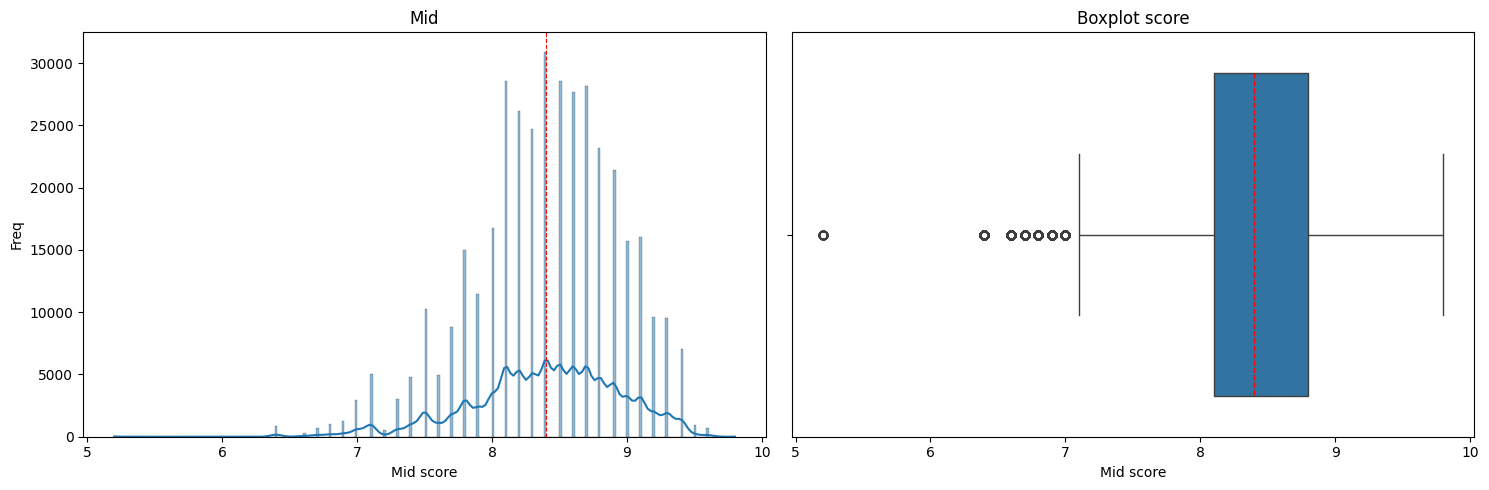

In [46]:
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Гистограмма в axes[0]
sns.histplot(df['average_score'], kde=True, ax=axes[0])
axes[0].set(xlabel='Mid score', ylabel='Freq')
axes[0].set_title('Mid')
axes[0].axvline(df['average_score'].mean(), color='red', linestyle='--', linewidth=0.8)

# Боксплот в axes[1]sns.boxplot(df['average_score'], orient='h', ax=axes[1], medianprops={"color": "red", "linestyle": '--'})
sns.boxplot(df['average_score'], orient='h', ax=axes[1], 
            medianprops={"color": "red", "linestyle": '--'})
axes[1].set(xlabel='Mid score')
axes[1].set_title('Boxplot score')


plt.tight_layout()  # Чтобы избежать наложения подписей
plt.show()

<Axes: >

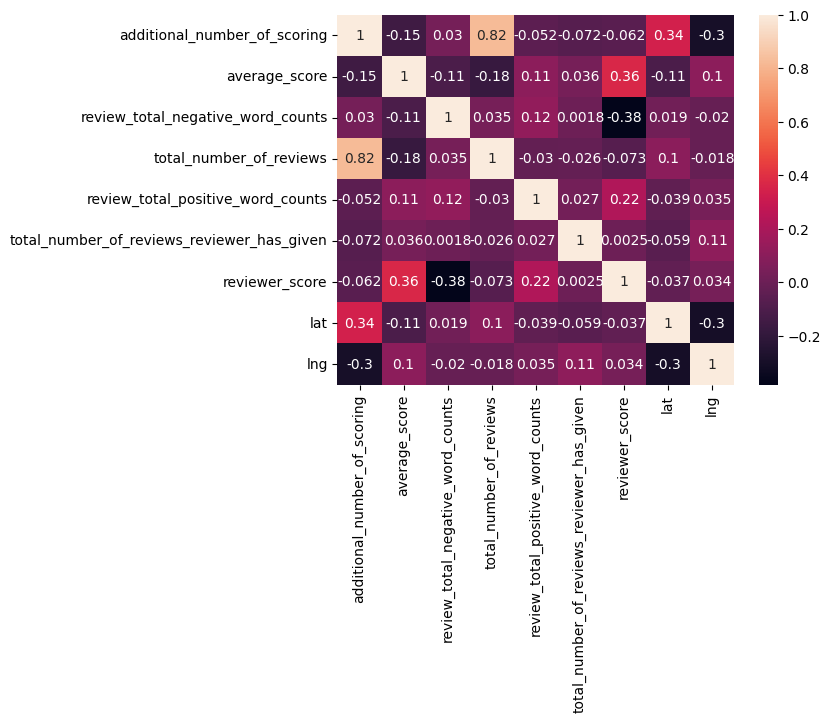

In [47]:
sns.heatmap(num_cols.corr(), annot=True)

# и Cтатистические тесты

Проверка на нормальность данных

In [48]:
from scipy.stats import shapiro

group_tot_num_rev = df['total_number_of_reviews']
group_revr_score = df['reviewer_score']
group_tot_num_has_giv = df['total_number_of_reviews_reviewer_has_given']

print("Shapiro :", shapiro(group_tot_num_rev).pvalue)
print("Shapiro :", shapiro(group_revr_score).pvalue)
print("Shapiro :", shapiro(group_tot_num_has_giv).pvalue)


Shapiro : 7.924679341903614e-159
Shapiro : 3.691117557932966e-149
Shapiro : 2.9785462128223767e-189


c:\Users\Lenovo\AppData\Local\Programs\Python\Python313\Lib\site-packages\scipy\stats\_axis_nan_policy.py:579: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 386803.
  res = hypotest_fun_out(*samples, **kwds)


Данные ненормальные применяю метод Краскела-Уолиса


**Сформулируем нулевую и альтернативные гипотезы**

*Нулевая гипотеза* ($H_0$): Зарплаты одинаковы.


*Альтернативная гипотеза* ($H_1$): Зарплаты DS-специалистов в разных по размеру компаниях неодинаковы.

In [49]:
alpha = 0.05 # берём стандартное значение

_, p = stats.kruskal(group_tot_num_rev, group_revr_score, group_tot_num_has_giv)

print('p-value = {:.3f}'.format(p))

if p <= alpha:
    print('p-значение меньше, чем заданный уровень значимости {:.2f}. Отвергаем нулевую гипотезу.'.format(alpha))
else:
    print('p-значение больше, чем заданный уровень значимости {:.2f}. У нас нет оснований отвергнуть нулевую гипотезу.'.format(alpha))

p-value = 0.000
p-значение меньше, чем заданный уровень значимости 0.05. Отвергаем нулевую гипотезу.


Тест даёт нам понять что признаки не равны в своих весах на среднее значение рейтинга

Проверка ещё ожних признаков на значимость

In [50]:
gr_rev_mth = df['review_month']
gr_s_rev = df['days_since_review']
gr_rev_year = df['review_year']  


print("Shapiro :", shapiro(gr_rev_mth).pvalue)
print("Shapiro :", shapiro(gr_s_rev).pvalue)
print("Shapiro :", shapiro(gr_rev_year).pvalue)

Shapiro : 1.9790810504531338e-119
Shapiro : 4.0516277998666655e-113
Shapiro : 8.576384769838011e-162


Данные снова не нормальные


**Сформулируем нулевую и альтернативные гипотезы**

*Нулевая гипотеза* ($H_0$): Зарплаты одинаковы.


*Альтернативная гипотеза* ($H_1$): Зарплаты DS-специалистов в разных по размеру компаниях неодинаковы.

In [51]:
alpha = 0.05 # берём стандартное значение

_, p = stats.kruskal(gr_rev_mth, gr_rev_year)

print('p-value = {:.3f}'.format(p))

if p <= alpha:
    print('p-значение меньше, чем заданный уровень значимости {:.2f}. Отвергаем нулевую гипотезу.'.format(alpha))
else:
    print('p-значение больше, чем заданный уровень значимости {:.2f}. У нас нет оснований отвергнуть нулевую гипотезу.'.format(alpha))

p-value = 0.000
p-значение меньше, чем заданный уровень значимости 0.05. Отвергаем нулевую гипотезу.


Тест даёт нам понять что признаки не равны в своих весах на среднее значение рейтинга

In [52]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

# Расчёт VIF
X = df[['reviewer_score', 'total_number_of_reviews', 'review_total_positive_word_counts']]
vif_data = pd.DataFrame()
vif_data["feature"] = X.columns
vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
print(vif_data)

                             feature       VIF
0                     reviewer_score  3.026046
1            total_number_of_reviews  2.219545
2  review_total_positive_word_counts  1.749746


In [53]:
top_tags = pd.Series([tag for sublist in df['tags'] for tag in sublist]).value_counts().head(5).index

for tag in top_tags:
    df[f'tag_{tag}'] = df['tags'].apply(lambda x: 1 if tag in x else 0)

# Удаляем исходный столбец
df.drop('tags', axis=1, inplace=True)

# Новые признаки


Временные признаки

In [54]:
# День недели отзыва (понедельник=0, воскресенье=6)
df['review_day_of_week'] = pd.to_datetime(df['review_date']).dt.dayofweek

# Время года (сезон)
df['review_season'] = pd.to_datetime(df['review_date']).dt.month % 12 // 3 + 1  # 1-зима, 2-весна и т.д.

# Разница между датой отзыва и текущей датой (актуальность)
df['days_since_review_to_today'] = (pd.to_datetime('today') - pd.to_datetime(df['review_date'])).dt.days

Активность рецензента 

In [55]:
# Средняя оценка рецензента по всем его отзывам
df['reviewer_avg_score'] = df.groupby('reviewer_nationality')['reviewer_score'].transform('mean')

# Отношение числа отзывов рецензента к среднему по датасету
df['reviewer_activity_ratio'] = df['total_number_of_reviews_reviewer_has_given'] / df['total_number_of_reviews_reviewer_has_given'].mean()

# Время между отзывами рецензента (если есть временная последовательность)
df['days_since_last_review'] = df.groupby('reviewer_nationality')['review_date'].diff().dt.days

Отношение признаков

In [56]:
# Разница между оценкой рецензента и средним баллом отеля
df['score_diff'] = df['reviewer_score'] - df['average_score']

# Очистка непригодных признаков(на мой взгляд)

In [57]:
df.columns

Index(['hotel_address', 'additional_number_of_scoring', 'review_date',
       'average_score', 'hotel_name', 'reviewer_nationality',
       'negative_review', 'review_total_negative_word_counts',
       'total_number_of_reviews', 'positive_review',
       'review_total_positive_word_counts',
       'total_number_of_reviews_reviewer_has_given', 'reviewer_score',
       'days_since_review', 'lat', 'lng', 'review_year', 'review_month',
       'review_day', 'tag_ ', 'tag_'', 'tag_e', 'tag_i', 'tag_o',
       'review_day_of_week', 'review_season', 'days_since_review_to_today',
       'reviewer_avg_score', 'reviewer_activity_ratio',
       'days_since_last_review', 'score_diff'],
      dtype='object')

In [58]:
# Удаляю эти признаки,так как у нас есть признаки с подсчитаннымми негативными и позитивными словами
# Которые мы можем перекодировать.В противном случае потребовалась бы обрабортка этих признаков
# Ещё можно удалить адресса отелей так, геолокация в какойто степени дублирует этот признак(о я пока этого делать не буду)

df.drop('additional_number_of_scoring', axis=1, inplace=True) #удаляем так как он мультикол-н и менее информативен по сравнению с total_number_of_reviews
df.drop('positive_review', axis=1, inplace=True)
df.drop('negative_review', axis=1, inplace=True)

# Кодировка признаков

In [59]:
binary_encoder = BinaryEncoder(cols=['days_since_review'])
encoded = binary_encoder.fit_transform(df[['days_since_review']])
df = pd.concat([df, encoded], axis=1)

In [60]:
encoder = ce.OneHotEncoder(cols=['review_year'], use_cat_names=True) 
type_bin = encoder.fit_transform(df['review_year'])
df = pd.concat([df, type_bin], axis=1)

In [61]:
encoder = ce.OneHotEncoder(cols=['review_day'], use_cat_names=True) 
type_bin = encoder.fit_transform(df['review_day'])
df = pd.concat([df, type_bin], axis=1)

In [62]:
binary_encoder = BinaryEncoder(cols=['review_year'])
train_encoded = binary_encoder.fit_transform(df[['review_year']])
df = pd.concat([df, train_encoded], axis=1)

In [63]:
binary_encoder = BinaryEncoder(cols=['days_since_review'])
encoded = binary_encoder.fit_transform(df[['days_since_review']])
df = pd.concat([df, encoded], axis=1)

In [64]:
binary_encoder = BinaryEncoder(cols=['hotel_address'])
encoded = binary_encoder.fit_transform(df[['hotel_address']])
df = pd.concat([df, encoded], axis=1)
df.drop('hotel_address', axis=1, inplace=True)

In [65]:
binary_encoder = BinaryEncoder(cols=['hotel_name'])
encoded = binary_encoder.fit_transform(df[['hotel_name']])
df = pd.concat([df, encoded], axis=1)
df.drop('hotel_name', axis=1, inplace=True)

In [66]:
binary_encoder = BinaryEncoder(cols=['reviewer_nationality'])
encoded = binary_encoder.fit_transform(df[['reviewer_nationality']])
df = pd.concat([df, encoded], axis=1)
df.drop('reviewer_nationality', axis=1, inplace=True)

In [67]:
binary_encoder = BinaryEncoder(cols=['days_since_review'])
encoded = binary_encoder.fit_transform(df[['days_since_review']])
df = pd.concat([df, encoded], axis=1)

In [68]:
df.drop('days_since_review',axis=1 ,inplace=True)

In [69]:
df.drop('review_date', axis=1, inplace=True)

# Модель обучения


In [70]:
# Разбиваем датафрейм на части, необходимые для обучения и тестирования модели  
    # Х — данные с информацией об отелях, у — целевая переменная (рейтинги отелей)  
X = df.drop(['reviewer_score'], axis = 1)  
y = df['reviewer_score'] 


from sklearn.feature_selection import VarianceThreshold
X = X
sel = VarianceThreshold(threshold=(.8 * (1 - .8)))
sel.fit_transform(X) 
      
      
    # Загружаем специальный инструмент для разбивки:  
from sklearn.model_selection import train_test_split  
      
    # Наборы данных с меткой "train" будут использоваться для обучения модели, "test" — для тестирования.  
    # Для тестирования мы будем использовать 25 % от исходного датасета.  
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)


# Импортируем необходимые библиотеки:  
from sklearn.ensemble import RandomForestRegressor # инструмент для создания и обучения модели  
from sklearn import metrics # инструменты для оценки точности модели  
      
    # Создаём модель  
regr = RandomForestRegressor(n_estimators=100)  
      
    # Обучаем модель на тестовом наборе данных  
regr.fit(X_train, y_train)  
      
    # Используем обученную модель для предсказания рейтинга отелей в тестовой выборке.  
    # Предсказанные значения записываем в переменную y_pred  
y_pred = regr.predict(X_test)

    # Сравниваем предсказанные значения (y_pred) с реальными (y_test) и смотрим, насколько они отличаются  
    # Метрика называется Mean Absolute Percentage Error (MAPE) и показывает среднюю абсолютную процентную ошибку предсказанных значений в отношении фактических.  
print('MAPE:', metrics.mean_absolute_percentage_error(y_test, y_pred))

MAPE: 0.00015554090900150362


In [71]:
a,b,c,d = 0.13319662243237387,0.13370915639119663,0.13377706436030937,0.1333508237592271